In [1]:
%pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings('ignore')

from darts.models import (
    Prophet
)
from darts.metrics import mape, mae
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError
from darts.utils.likelihood_models import QuantileRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
# # data = data.resample('H').sum(min_count=1)
# data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
TEST_END = '2022-01-01'
TRAIN_END = '2021-01-01'
TRAIN_END = pd.to_datetime(TRAIN_END)
data = data.loc[data.index < TEST_END]
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])
data

,Consumption,Temperature,Covid
Date,,,
2018-01-01 00:00:00+00:00,437079.017331,4.191667,0
2018-01-02 00:00:00+00:00,441247.012018,2.158333,0
2018-01-03 00:00:00+00:00,428372.492620,2.604167,0
2018-01-04 00:00:00+00:00,432217.202020,1.508333,0
2018-01-05 00:00:00+00:00,410469.442938,3.991667,0
...,...,...,...
2021-12-27 00:00:00+00:00,451012.930925,3.604167,0
2021-12-28 00:00:00+00:00,445811.645751,4.650000,0
2021-12-29 00:00:00+00:00,454444.875945,3.537500,0


Data

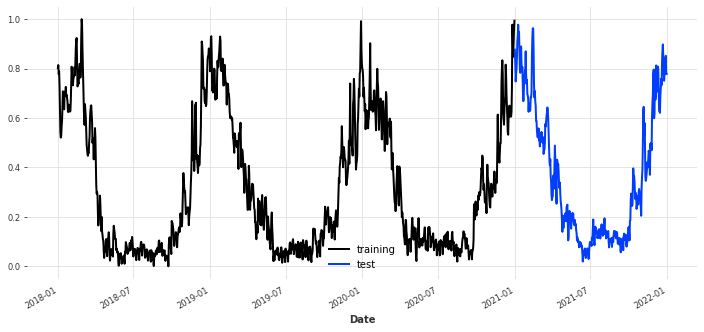

In [ ]:
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='Consumption')
series_unsc = series
series = series_scaler.fit_transform(series)

train, test = series.split_before(TRAIN_END)
train_unsc, test_unsc = series_unsc.split_before(TRAIN_END)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

Covariates

Text(0.5, 1.0, 'Covariates (Covid)')

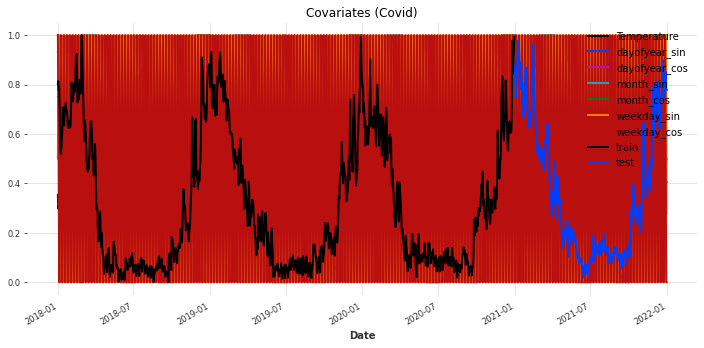

In [ ]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year = datetime_attribute_timeseries(series, attribute="year")
month = datetime_attribute_timeseries(series, attribute="month", cyclic=True)
weekday = datetime_attribute_timeseries(series, attribute="weekday", cyclic=True)
dayofyear = datetime_attribute_timeseries(series, attribute="dayofyear", cyclic=True)
temperature = TimeSeries.from_dataframe(df=data, value_cols='Temperature')
future_scaler = Scaler()


### future and past
future_covariates = temperature.stack(dayofyear).stack(month).stack(weekday)
future_covariates = future_scaler.fit_transform(future_covariates)


plt.figure(101, figsize=(12, 5))
future_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

NBeats

In [ ]:
# A TorchMetric or val_loss can be used as the monitor

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
N_SAMPLES = 100

pr = Prophet(add_encoders={
    'cyclic': {'future': ['dayofyear']},
    'transformer': Scaler()
})

In [ ]:
pr.fit(series=train_unsc)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpncdio20u/ygzhwvp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpncdio20u/wavl979f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63161', 'data', 'file=/tmp/tmpncdio20u/ygzhwvp9.json', 'init=/tmp/tmpncdio20u/wavl979f.json', 'output', 'file=/tmp/tmpncdio20u/prophet_modelutpnfd2p/prophet_model-20230116114949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:49:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


36019.385087272785
14.237439392210494


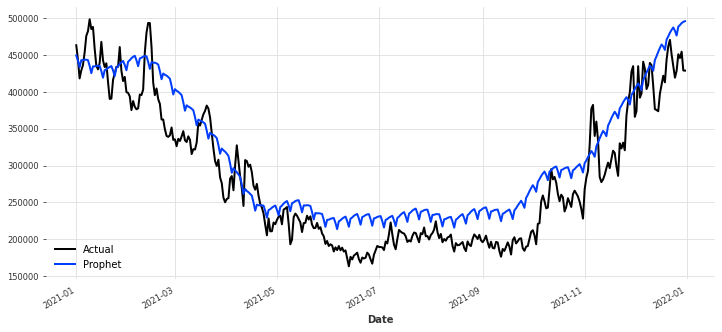

In [ ]:
pred = pr.predict(n=365)
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred.plot(label='Prophet')
print(mae(test_unsc, pred))
print(mape(test_unsc, pred))

NHITS

In [ ]:
nhits = NHiTSModel(
    input_chunk_length=32,
    output_chunk_length=1,
    layer_widths=128,
    dropout=0.1,
    batch_size=32,
    model_name='TestModelHits',
    save_checkpoints=True,
    # add_encoders=None,
    #loss_fn=torch.nn.MSELoss,
    # optimizer_cls=torch.optim.Adam,
    #optimizer_kwargs={'lr': 1e-4},
    likelihood=QuantileRegression(quantiles=QUANTILES), 
    #pl_trainer_kwargs=pl_trainer_kwargs
)

In [ ]:
nhits.fit(series=train,
        past_covariates=past_covariates,
        val_series=test,
        val_past_covariates=past_covariates,
        epochs=200,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 213 K 
---------------------------------------------------
180 K     Trainable params
33.0 K    Non-trainable params
213 K     Total params
1.709     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
best_nhits = nhits.load_from_checkpoint(model_name='TestModelHits', best=True)

ERROR:darts.models.forecasting.torch_forecasting_model:ValueError: Could not find base model save file `_model.pth.tar` in /content/darts_logs/TestModelHits.


ValueError: ignored

In [ ]:
scaled_pred_nhits = best_nhits.predict(n=365, past_covariates=past_covariates, num_samples=N_SAMPLES)
pred_nhits = series_scaler.inverse_transform(scaled_pred_nhits)

In [ ]:
print(mape(test, scaled_pred_nhits))

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
pred_nhits.plot(label='NHits')
print(mae(test_unsc, pred_nhits))
print(mape(test_unsc, pred_nhits))